# Exercise 8.1 - Solution
### Classification of magnetic phases using CNNs

Imagine a 2-dimensional lattice arrangement of $n \times n$ magnetic dipole moments (spins) that can be in one of two states ($+1$ or $−1$, Ising model).
With interactions between spins being short ranged, each spin interacts only with its four neighbors.
The probability to find a spin in one of the orientations is a function of temperature $T$ according to $p \sim e^{−a/T},\;a = \mathrm{const.}$).

At extremely low temperatures $T \rightarrow 0$, neighboring spins have a very low probability of different orientations, so that a uniform overall state (ferromagnetic state) is adopted, characterized by $+1$ or $−1$.
At very high temperatures $T \rightarrow \infty$, a paramagnetic phase with random spin alignment results, yielding $50\%$ of $+1$ and $0%$ of $−1$ orientations.
Below a critical temperature $0 < T < T_c$, stable ferromagnetic domains emerge, with both orientations being equally probable in the absence of an external magnetic field.
The spin-spin correlation function diverges at $T_c$, whereas the correlation decays for $T > T_c$.

The data for this task contain the $n \times n$ dipole orientations on the lattice for different temperatures $T$.
Classify the two magnetic phases (paramagnetic/ferromagnetic) using a convolutional neural network!

In [12]:
from tensorflow import keras
import numpy as np
callbacks = keras.callbacks
layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


### Load and prepare dataset
See https://doi.org/10.1038/nphys4035 for more information

In [2]:
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
output = 'ising_data.npz'
gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

### Plot data

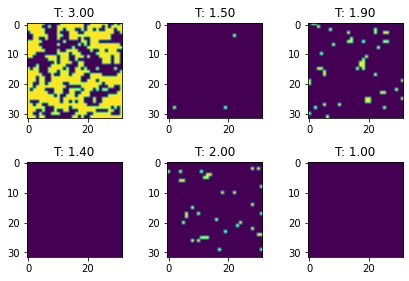

In [3]:
import matplotlib.pyplot as plt

for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = x_train[j]
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

Text(0, 0.5, 'frequency')

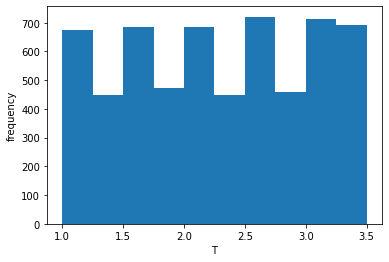

In [4]:
plt.hist(T_test)
plt.xlabel("T")
plt.ylabel("frequency")

#### Set up training data - define magnetic phases

In [5]:
Tc = 2.27
y_train, y_test = T_train > Tc, T_test > Tc

 ### Task

 - evaluate the test accuracy for a convolutional network,
 - plot the test accuracy vs. temperature.
 - compare to the results obtained using a fully-connected network (Exercise 7.1)

In [6]:
model = keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32)))
model.add(layers.Reshape((32, 32,1)))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

### prepare model for training

In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])


In [8]:
results = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[
                        callbacks.EarlyStopping(patience=5, verbose=1),
                        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)]
                    )

Epoch 1/50
282/282 - 10s - loss: 0.0859 - accuracy: 0.9613 - val_loss: 0.0413 - val_accuracy: 0.9820
Epoch 2/50
282/282 - 14s - loss: 0.0448 - accuracy: 0.9805 - val_loss: 0.0366 - val_accuracy: 0.9835
Epoch 3/50
282/282 - 14s - loss: 0.0443 - accuracy: 0.9821 - val_loss: 0.0365 - val_accuracy: 0.9835
Epoch 4/50
282/282 - 14s - loss: 0.0458 - accuracy: 0.9795 - val_loss: 0.0373 - val_accuracy: 0.9850
Epoch 5/50
282/282 - 13s - loss: 0.0442 - accuracy: 0.9808 - val_loss: 0.0367 - val_accuracy: 0.9850

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 6/50
282/282 - 13s - loss: 0.0413 - accuracy: 0.9822 - val_loss: 0.0366 - val_accuracy: 0.9855
Epoch 7/50
282/282 - 14s - loss: 0.0404 - accuracy: 0.9816 - val_loss: 0.0365 - val_accuracy: 0.9855

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 8/50
282/282 - 13s - loss: 0.0396 - accuracy: 0.9827 - val_loss: 0.0376 - val_accuracy: 0.9810
Epoch 00008: early stopping


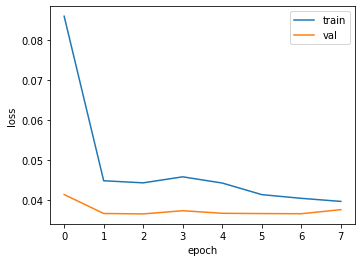

In [9]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

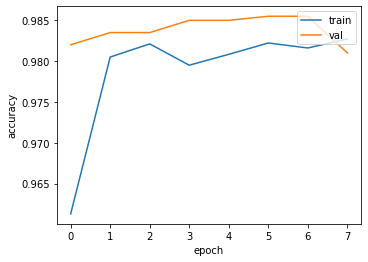

In [10]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

### Evaluate training

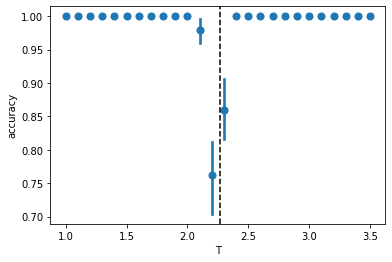

In [11]:
import seaborn as sns

preds = model.predict(x_test).round().squeeze()
acc = (preds == y_test).astype(np.float)

ax = sns.regplot(x=T_test, y=acc, x_estimator= np.mean, fit_reg=False)
ax.set_ylabel("accuracy")
ax.set_xlabel("T")
plt.axvline(x=Tc, color='k', linestyle='--', label='Tc')